In [23]:
from scipy.stats import ttest_1samp
import numpy as np
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

from scipy.stats import shapiro
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [3]:
df = pd.read_excel("C:/Users/kokse/Downloads/AB_Test_Results.xlsx")
df.head(10)

,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


### Все типы столбцов корректны, нулевых строк нету

In [5]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [6]:
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [7]:
df.VARIANT_NAME.value_counts()

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

### Размеры групп примерно одинаковые

In [12]:
#Избавимся от некорретных строк. Посчитаем, сколько строчек встречается у каждого пользователя.

variants = df.\
    groupby('USER_ID', as_index=False).\
    agg({'VARIANT_NAME': pd.Series.nunique})

In [13]:
variants.head(10)

,USER_ID,VARIANT_NAME
0,2,1
1,3,2
2,4,1
3,5,1
4,6,1
5,9,1
6,10,2
7,11,1
8,12,1
9,13,1


In [15]:
# Отфильтруем юзеров которые повторяются

more_than_one_types = variants.query('VARIANT_NAME > 1')

In [16]:
# Убираем повторы

df_new = df[~df.USER_ID.isin(more_than_one_types.USER_ID)].sort_values('USER_ID')

In [17]:
# Смотрим количество уникальных пользователей

df_new.shape


(6070, 3)

## __На данном этапе можно понять, что сплитование пользователей происходит некорректно, так как повторяющихся по user_id около 40%__


In [18]:
# Проверяем исходный датасет
df.shape


(10000, 3)

In [20]:
# Делим на группы
control = df_new.query('VARIANT_NAME == "control"')

test = df_new.query('VARIANT_NAME == "variant"')

In [21]:
# Смотрим количество юзеров в контрольной группе
len(control)

3026

In [22]:
# Смотрим количество юзеров в тестовой группе
len(test)

3044

In [33]:
# проверяем выборки на нормальность
alpha = 0.05

st = stats.shapiro(df.REVENUE)
print('Distribution is {}normal\n'.format( {True:'not ',
False:''}[st[1] < alpha]));

Distribution is not normal



#### Распределение - не нормальное

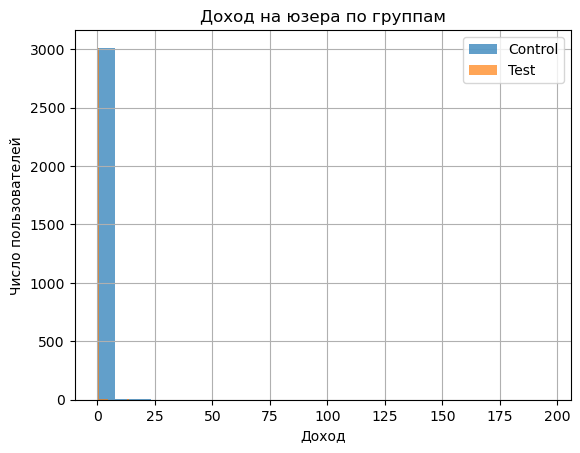

In [25]:
# Смотрим распределение визуально
control.REVENUE.hist(bins = 25, alpha =0.7, label='Control')
test.REVENUE.hist(bins = 25, alpha =0.7, label='Test')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

#### 

In [34]:
# Применяем Mannwhitneyu
mw_stats = stats.mannwhitneyu(x=control.REVENUE.values, y=test.REVENUE.values)
mw_stats

MannwhitneyuResult(statistic=4622832.0, pvalue=0.2444173738649208)

### p_value ~ 24, 4%

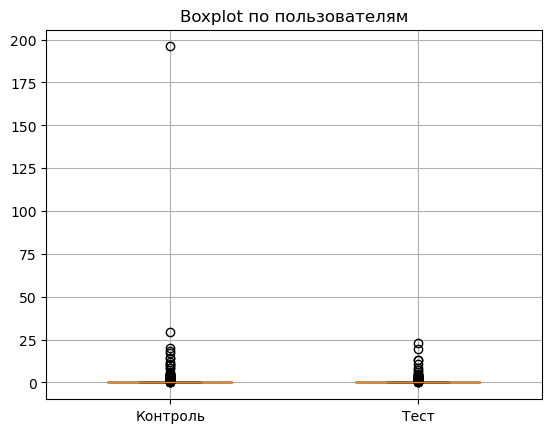

In [26]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

### Рекомендации
#### Cплитование пользователей происходит некорректно, так как повторяющихся по user_id около 40%, поэтому сначала нужно правильно настроить сплитование
#### P больше 0,05 - у нас недостаточно данных, чтобы быть уверенным в том, что мы не допустим ошибку первого порядка, а это значит, что мы не можем отвергнуть нулевую теорию.
#### При такой дисперсии и таком alpha стат значимых различий нет

